# Imports

In [83]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Import the Data

In [85]:
round_data = pd.read_csv('golf_round_data.csv').set_index('Unnamed: 0')
round_data['event_completed'] = pd.to_datetime(round_data['event_completed'])

Take our round data created in the previous notebook for factor creation. We need to "fill" the temporal asepcts. So, we get rid of observations from 2017, and use them to fill temporal aspects moving forward from that date.

NOTE: We aren't going to train the data on the "unknown" players. I would train the unknown players seperately, but there would be a lot of new factor-creation and seperate data to be introduced. My focus in this project will be on players that we actually have a good amount of data on. 

In [86]:
round_data = round_data[round_data['unknownplayer']==0]

# Create train and test (validation) sets for 2018 and 2019

For the first model, we will be using the 2018 season to train it, and the 2019 year to validate/test the results. 

In [87]:
# rounds in any year after 2017
round_data = round_data[round_data['event_completed']>'2017'].dropna()

In [88]:
# rounds from 2018 to 2019/06
train = round_data[round_data['event_completed'] < '2019/06']

In [89]:
# rounds from 2019/06 UP TO 2020
test = round_data[(round_data['event_completed'] >= '2019/06') & (round_data['event_completed'] < '2020')]

# First Linear Regression Test

Work through factors (excluding course, strokes gained specefics) and see which have a noticable effect on the predictablity of the model. I will begin by assesing the round factors and how they work:

**Start by looking at the round factors**:

In [90]:
# Choose the columns to test with this first regression
columns = ['prev_round_tournament','sg_event_strength', 'stSG_adjusted',
           'halflifeSG_strength', 'roundsplayed','round_2', 'round_3', 'round_4']

In [91]:
# set the train and test sets
# Train:
X_train = train[columns]
y_train = train['sg_total']

# Test:
X_test = test[columns]
y_test = test['sg_total']

In [92]:
# have to add constant when working with statsmodels
X = sm.add_constant(X_train)
est = sm.OLS(y_train, X)
fii = est.fit()

fii.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:                OLS              Adj. R-squared:     0.047      
Dependent Variable:   sg_total         AIC:                136108.8140
Date:                 2022-07-04 23:57 BIC:                136182.9288
No. Observations:     27861            Log-Likelihood:     -68045.    
Df Model:             8                F-statistic:        171.9      
Df Residuals:         27852            Prob (F-statistic): 1.56e-284  
R-squared:            0.047            Scale:              7.7453     
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                  0.4448   0.0508   8.7576 0.0000  0.3453  0.5444
prev_round_tournament  0.0279   0.0070   3.9798 0.0001  0.0141  0.0416
sg_event_strength     -1.0000   0.0571 -17.5216 0.0000 -1.1119 -0.8882
stSG_adjusted          0.0869   0.0239   3.6416 0.0003  0.0401  0.1337
halflifeSG_strength    0.7111   0.0339  21.0069 0.0000  0.6447  0.7774
roundsplayed          -0.0026   0.0005  -5.3518 0.0000 -0.0035 -0.0016
round_2               -0.0603   0.0429  -1.4057 0.1598 -0.1444  0.0238
round_3               -0.1283   0.0517  -2.4838 0.0130 -0.2296 -0.0271
round_4               -0.1175   0.0508  -2.3122 0.0208 -0.2172 -0.0179
----------------------------------------------------------------------
Omnibus:               429.777        Durbin-Watson:           1.385  
Prob(Omnibus):         0.000          Jarque-Bera (JB):        478.423
Skew:                  -0.270         Prob(JB):                0.000  
Kurtosis:              3.348          Condition No.:           417    
======================================================================

"""

So, it looks like round 3 and round 4 have some sort of small realtion to the model output, while round 2 does not. This probably points to weekend rounds being harder (lower strokes gained prediction). So, test the model with the weekend indicator instead. 

In [93]:
# Choose the columns to test with this first regression
columns = ['prev_round_tournament','sg_event_strength', 'stSG_adjusted',
           'halflifeSG_strength', 'roundsplayed','Weekend_round']

In [94]:
# Train:
X_train = train[columns]
y_train = train['sg_total']

# Test:
X_test = test[columns]
y_test = test['sg_total']

In [95]:
# have to add constant when working with statsmodels
X = sm.add_constant(X_train)
est = sm.OLS(y_train, X)
fii = est.fit()

fii.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:                OLS              Adj. R-squared:     0.047      
Dependent Variable:   sg_total         AIC:                136106.8238
Date:                 2022-07-04 23:57 BIC:                136164.4687
No. Observations:     27861            Log-Likelihood:     -68046.    
Df Model:             6                F-statistic:        228.9      
Df Residuals:         27854            Prob (F-statistic): 1.85e-286  
R-squared:            0.047            Scale:              7.7453     
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                  0.4149   0.0461   9.0011 0.0000  0.3245  0.5052
prev_round_tournament  0.0268   0.0069   3.8873 0.0001  0.0133  0.0403
sg_event_strength     -1.0014   0.0571 -17.5484 0.0000 -1.1133 -0.8896
stSG_adjusted          0.0874   0.0239   3.6655 0.0002  0.0407  0.1342
halflifeSG_strength    0.7115   0.0338  21.0188 0.0000  0.6451  0.7778
roundsplayed          -0.0026   0.0005  -5.3604 0.0000 -0.0035 -0.0016
Weekend_round         -0.0917   0.0376  -2.4427 0.0146 -0.1654 -0.0181
----------------------------------------------------------------------
Omnibus:               431.252        Durbin-Watson:           1.384  
Prob(Omnibus):         0.000          Jarque-Bera (JB):        480.127
Skew:                  -0.270         Prob(JB):                0.000  
Kurtosis:              3.348          Condition No.:           332    
======================================================================

"""

So, now that the p-value for this factor is at a reasonable level for it to be kept, it is worth mentioning now that roundsplayed can be dropped. The factor is marginal to the prediction, and also has a realtively high p-value. So, now move to the final model. 

# Final model and test scores

In [96]:
# Choose the columns to test with this final regression
columns = ['prev_round_tournament','sg_event_strength', 'stSG_adjusted',
           'halflifeSG_strength','unknownplayer','Weekend_round']

In [97]:
# Train:
X_train = train[columns]
y_train = train['sg_total']

# Test:
X_test = test[columns]
y_test = test['sg_total']

In [98]:
# 1. Instanitate model
linear_regression_model = LinearRegression()


# 2. Fit model
linear_regression_model.fit(X_train,y_train)

# 3. Score on the test set
linear_regression_model.score(X_test,y_test)

0.04635763599252862

**Save the model using pickle**

In [99]:
import pickle

In [100]:
pickle.dump(linear_regression_model, open('golf_linear_model.pkl', 'wb'))

# Analyzing the model

So, it is a good idea to start by discussing the results of the model and the "good" and "bad" of the prediction model. 

**The "good"**

- The model is making predictions that mirror common knowledge. For example, historical strength of a player has the largest sway in how strong a model feels about a positive prediction. So historically good players are going to have high predicted strokes gained for a round. 
- This is the same for the "unknown" players. Although it is a little rudementary to assume all unknown players should be treated the same, in general the fact that they have not played in many pga events within a certain time frame means they are going to be worse than the average player. This makes sense as well. 
- Another important factor that the model is weighting highly is the event's strength. Again, this makes sense because a weaker field of golfers means that the strokes gained for all players will probably be higher. If you do not have as many good players in the field, than weaker player's will probably get better strokes gained scores than they "deserve". 

**The "bad"**
- This one is really important, and it is that the R squared score is very, very low. So, a very small of the variance can be predicted with the factors. Bascially, a golfer's performance from round to round is very noisey and random. Good players play badly alot, and bad players play well. Also, outliers are fairly common round to round.
- Unknown players are all treated the same. This more has to do with the limitations of the data, but there might be some really, really good unknown players and the model would just assume they are bad. It is not entirely unlikely for a guy to burst onto the scene from college or the European Tour and play consistently well. Luckily, if this is the case the model will catch up once it has enough knowledge on the player. 
- Alot of things aren't explained in the model. For example, how a course is setup will fit certain players better than others. Longer course setups will probably favor guys that hit it longer, but the linear model is really unable to adjust to factor this in. And, when the course setup is the same for quite a few rounds, so doing a course fit adjustment on the round level is probably not the greatest idea. This is something that we will look into. 

**BUT :**


Luckily, a golf tournament isn't only one round! A player will play the same course at least two times in a given week. This means that it might be worth analyzing how this model predicts scores at a tournament level.

# Looking into the predictions

Let's create the predictions for the test set and look into the results.

First thing to look at is the confidence intervals for the train set. This is nice to know because it will put the "confidence" of the model in a more understandable context. 

In [101]:
# alpha will be the confidence interval we want. In this case, it is 0.05 to 0.95.
alpha = 0.05

# create the residuals for the train set
residuals = y_train - linear_regression_model.predict(X_train)

# calculate the confidence interval using the alpha set from before
ci = np.quantile(residuals, 1 - alpha)
print(f'The confidence interval for the linear model is: {ci}')

# using the CI, run the generate results function to create dataframe for analysis
preds = linear_regression_model.predict(X_test)

The confidence interval for the linear model is: 4.385052451964826


So, we can reasonably expect that the result will fall within ~4.4 shots of the prediction. Clearly, our model is not very confident. But, as we said before, a tournament is multiple rounds. Let's look at how the confidence intervals change when predicting for two rounds. 

Let's look at Thursday/Friday rounds (before the cut) to see how the confidence intervals change. 

In [102]:
# alpha will be the confidence interval we want. In this case, it is 0.05 to 0.95.
alpha = 0.05

# create the residuals for the train set
residuals = y_train - linear_regression_model.predict(X_train)

# calculate the confidence interval using the alpha set from before
ci = np.quantile(residuals, 1 - alpha)
print(f'The confidence interval for the linear model is: {ci}')

# using the CI, run the generate results function to create dataframe for analysis
preds = linear_regression_model.predict(X_test)

The confidence interval for the linear model is: 4.385052451964826


In [103]:
prediction_frame = test.copy()

In [104]:
test['predicted_SG'] = preds
test['residuals'] = test['sg_total'] - test['predicted_SG']

# Let's look at how the predictions go for a singular tournament

Import plotly for the visualizations:

In [105]:
import plotly.express as px
import plotly.graph_objects as go

Pull out one tournament for analysis. Then, split the rounds up for analysis of weekend and weekday rounds and the whole tournament by player.

In [106]:
# choose the 2019 memorial tournament
memorial = test[test['event_completed']=='2019-06-02']

# get the 'weekday' rounds
ThursFri = memorial[memorial['Weekend_round']==0]
# get the 'weekend' rounds
SatSun = memorial[memorial['Weekend_round']==1]

In [107]:
# Group by player, take the mean of the scores. 
ThursFri = ThursFri.groupby('player_name').mean().reset_index()
SatSun = SatSun.groupby('player_name').mean().reset_index()
Whole = memorial.groupby('player_name').mean().reset_index()

Create the plotly graphs. Color is the residual of the guess (how good or bad the guess was). Y-axis is the model's prediction, X-axis is what they actually shot in terms of strokes gained. 

In [108]:
px.scatter(data_frame=ThursFri, x='sg_total', y = 'predicted_SG', color=abs(ThursFri['residuals']), 
           color_continuous_scale=px.colors.sequential.Plotly3,
           hover_name = 'player_name', title='Weekday Predictions for the 2019 Memorial Tournament')

In [109]:
px.scatter(data_frame=SatSun, x='sg_total', y = 'predicted_SG', color=abs(SatSun['residuals']), 
           color_continuous_scale=px.colors.sequential.Plotly3,
           hover_name = 'player_name', title='Weekend Predictions for the 2019 Memorial Tournament')

In [110]:
px.scatter(data_frame=Whole, x='sg_total', y = 'predicted_SG', color=abs(Whole['residuals']), 
           color_continuous_scale=px.colors.sequential.Plotly3,
           hover_name = 'player_name', title='Total Predictions for the 2019 Memorial Tournament')

So, what can we understand from these visualizations? Quite a few important things to note.
1. The cut means that guys that miss the cut are going to have much higher residuals on average. This is could be a problem if we are going to do any sort of analysis on the residuals. 
2. Another thing to note is that the model is more "confident" in it's guesses as you play more rounds. This make's sense if we are assuming each round is normally distributed about the prediction.
3. The residuals are not totally continious, since at the end of the round, all players have to finish with a whole number in terms of their score. 

# Showing how playing more rounds increases "confidence" in the model, using normal distributions:

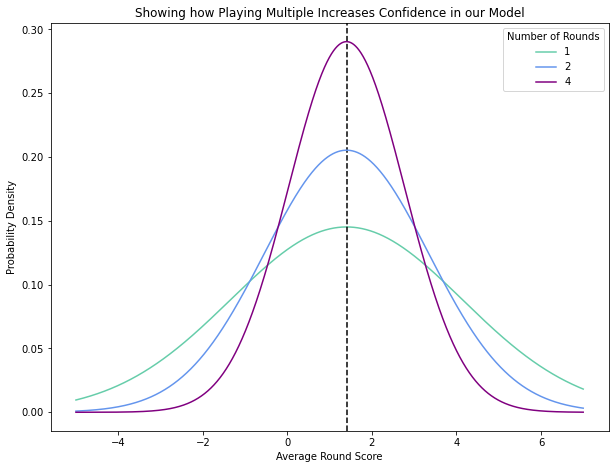

In [112]:
from scipy.stats import norm
# Get the mean squared error (which can be used to devise confidence intervals and variance/standard error)
s = mean_squared_error(y_test,preds)
x = np.arange(-5, 7, 0.001)
plt.figure(figsize=(10,7.5))
# Create a probability distribution function for a golfer with a mean predicted score of 1.4 Strokes Gained
plt.plot(x, norm.pdf(x, 1.4, np.sqrt(s)),label="1",color='mediumaquamarine')
plt.axvline(x=1.4,linestyle='--',color='black')

# Same pdf but with a sample size of 2
plt.plot(x, norm.pdf(x, 1.4, np.sqrt(s)/np.sqrt(2)),label="2",color='cornflowerblue')

# Same pdf but with a sample size of 4
plt.plot(x, norm.pdf(x, 1.4, np.sqrt(s)/np.sqrt(4)),label="4",color='purple')
plt.legend(title='Number of Rounds')
plt.xlabel('Average Round Score')
plt.title('Showing how Playing Multiple Increases Confidence in our Model')
plt.ylabel('Probability Density')
plt.show()
